# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.20 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


In [5]:
print('The state for the first agent looks like:', states[1])

The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.4669857  -1.5         0.          0.
 -6.83172083  6.          0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [6]:
for i in range(1):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [7]:
#env.close()

# TRAINING

In [10]:
import numpy as np
import random
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import copy
import torch

Episode 100	Average Reward: 0.011
Episode 200	Average Reward: 0.016
Episode 300	Average Reward: 0.026
Episode 400	Average Reward: 0.060
Episode 500	Average Reward: 0.115
Episode 600	Average Reward: 0.252
Episode 700	Average Reward: 0.434

Environment solved in 635 episodes!	Average Score: 0.505


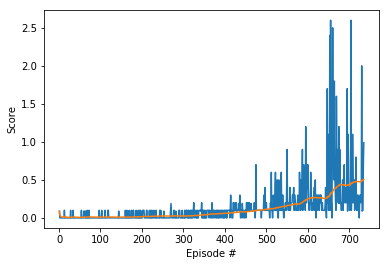

In [13]:
NOISE_START = 6
NOISE_END = 0
NOISE_DECAY = 500

from MADDPG_agent import Agent

agent_0 = Agent(state_size, action_size, 1, random_seed=0)
agent_1 = Agent(state_size, action_size, 1, random_seed=0)


n_episodes = 2000
scores_window = deque(maxlen=100)
scores_all = []
rolling_average = []

noise_schedule = lambda episode: max(NOISE_END, NOISE_START - episode * ((NOISE_START - NOISE_END) / NOISE_DECAY))

for i_episode in range(1, n_episodes+1):
    eps = noise_schedule(i_episode)
    env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
    states = env_info.vector_observations
    states = np.reshape(states, (1,48))
    agent_0.reset()    # Reset noise 
    agent_1.reset()    # Reset noise
    scores = np.zeros(num_agents)
    while True:
        action_0 = agent_0.act(states, eps)           # select an action for agent 0
        action_1 = agent_1.act(states, eps)           # select an action for agent 1
        actions = np.concatenate((action_0, action_1), axis=0)
        env_info = env.step(actions)[brain_name]           # send all actions to the environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        next_states = np.reshape(next_states, (1, 48))
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                         # see if episode finished
        
        if np.any(dones):                                   # if either agent fails, episode over
            done = True
        else:
            done = False
        
        # Here we flatten actions so that it can be properly sampled from the replaybuffer
        agent_0.step(states, actions.flatten(), rewards[0], next_states, done, 0)
        agent_1.step(states, actions.flatten(), rewards[1], next_states, done, 1)
        
        scores += rewards                                  # update the score (for each agent)
        states = next_states                                # roll over states to next time step

        if np.any(done):                                  # exit loop if episode finished
            break

    scores_window.append(np.max(scores))
    scores_all.append(np.max(scores))
    rolling_average.append(np.mean(scores_window))
                
    if i_episode % 100 == 0:
        print('Episode {}\tAverage Reward: {:.3f}'.format(
            i_episode, np.mean(scores_window)))

    if np.mean(scores_window)>=0.5:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(
            i_episode-100, np.mean(scores_window)))
        torch.save(agent_0.actor_local.state_dict(), 'checkpoint_actor_0.pth')
        torch.save(agent_0.critic_local.state_dict(), 'checkpoint_critic_0.pth')
        torch.save(agent_1.actor_local.state_dict(), 'checkpoint_actor_1.pth')
        torch.save(agent_1.critic_local.state_dict(), 'checkpoint_critic_1.pth')
        break


# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_all)+1), scores_all)
plt.plot(np.arange(1, len(rolling_average)+1), rolling_average)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()